In [1]:
import math
import numpy as np
import scipy
import scipy.stats as ss
import sklearn.cluster as skc
import matplotlib.pyplot as plt
import pandas
import time
from time import mktime
from datetime import datetime

#suppresses pandas indexing warning for cleaner output
#don't worry, I know what I'm doing :)
pandas.options.mode.chained_assignment = None  # default='warn'

admissions = pandas.read_csv('data/ADMISSIONS.csv')
patients = pandas.read_csv('data/PATIENTS.csv')
diagnoses_icd = pandas.read_csv('data/DIAGNOSES_ICD.csv')
d_icd_diagnoses = pandas.read_csv('data/D_ICD_DIAGNOSES.csv')
services = pandas.read_csv('data/SERVICES.csv')

In [2]:
#concatenate data
data = pandas.merge(admissions,patients,on='SUBJECT_ID',how='left')
data = pandas.merge(data,services,on='HADM_ID',how='left')
data.drop('SUBJECT_ID_y', axis=1, inplace=True)
data.drop('PREV_SERVICE', axis=1, inplace=True)
data.drop('ROW_ID_x', axis=1, inplace=True)
data.rename(columns={'SUBJECT_ID_x': 'SUBJECT_ID'}, inplace=True)

data_diagnoses_sparse = data.copy()

In [3]:
#parses date input of the form "YYYY-MM-DD HH:MM:SS"
#converts it to a datetime
def parse_time(time_str):
    if (pandas.notnull(time_str)):
        temp_time = time.strptime(time_str, "%Y-%m-%d %H:%M:%S")
        return datetime.fromtimestamp(mktime(temp_time))
    else:
        return time_str
    
def sec_between(x,y):
    return (parse_time(y) - parse_time(x)).total_seconds()

def calc_staylength(row):
    return sec_between(row['ADMITTIME'],row['DISCHTIME'])

def calc_age(row):
    return (sec_between(row['DOB'],row['ADMITTIME'])) if (row['ISOLD'] == 0) else (89)

def check_old(row):
    return 1 if(int((row['DOB'])[:4]) < 2000) else 0

In [4]:
data['ISOLD'] = data.apply(lambda row: check_old(row),axis=1)
data['STAYLENGTH'] = data.apply(lambda row: calc_staylength(row),axis=1)
data['AGE'] = data.apply(lambda row: calc_age(row),axis=1)
data['GENDER'] = data['GENDER'].map({'F':0,'M':1})

In [5]:
data['NEXTVISIT']=np.nan

sec_in_day = (60*60*24)
large_offset = 10000

for i in range(len(data)-1):
    if(data.ix[i,'SUBJECT_ID'] == data.ix[i+1,'SUBJECT_ID']):
        data.ix[i,'NEXTVISIT'] = sec_between(data.ix[i,'ADMITTIME'],data.ix[i+1,'ADMITTIME'])
    else:
        data.ix[i,'NEXTVISIT'] = sec_in_day * large_offset
data.ix[len(data)-1,'NEXTVISIT'] = sec_in_day * large_offset

data['STAYLENGTH'] = data['STAYLENGTH'] / sec_in_day
data['AGE'] = data['AGE'] / sec_in_day
data['NEXTVISIT'] = data['NEXTVISIT'] / sec_in_day

data.drop_duplicates(subset=['HADM_ID'])
data.reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  import sys


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ROW_ID,TRANSFERTIME,CURR_SERVICE,ISOLD,STAYLENGTH,AGE,NEXTVISIT
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,...,NaN,NaN,0,24.0,2196-04-09 12:27:00,MED,0,1.144444,23714.518056,10000.000000
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,...,NaN,NaN,0,25.0,2153-09-03 00:21:37,CSURG,0,5.496528,25980.302083,1506.513194
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,...,NaN,NaN,0,26.0,2157-10-18 19:34:59,NSURG,0,6.768056,27486.815278,10000.000000
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,...,NaN,NaN,0,27.0,2139-06-06 16:15:36,CMED,0,2.856944,14250.676389,10000.000000
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,...,NaN,NaN,0,28.0,2160-11-02 02:07:20,CMED,0,3.534028,21531.087500,10000.000000
5,26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,NaN,...,NaN,2128-02-25 00:00:00,1,29.0,2126-05-06 15:18:12,CMED,0,6.988889,26299.636111,10000.000000
6,27,134931,2191-11-30 22:16:00,2191-12-03 14:45:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,...,NaN,NaN,0,30.0,2191-11-30 22:21:15,NB,0,2.686806,0.927778,10000.000000
7,28,162569,2177-09-01 07:15:00,2177-09-06 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,...,NaN,NaN,0,31.0,2177-09-01 00:20:03,CSURG,0,5.364583,27168.302083,10000.000000
8,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,NaN,URGENT,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,NaN,...,NaN,NaN,0,32.0,2172-10-14 14:18:00,CMED,1,5.013889,0.001030,10000.000000
9,31,128652,2108-08-22 23:27:00,2108-08-30 15:00:00,2108-08-30 15:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,...,2108-08-30 00:00:00,2108-08-30 00:00:00,1,33.0,2108-08-22 23:28:42,MED,0,7.647917,26394.977083,0.000000


In [6]:
sample = data.copy()
sample.drop(['ADMITTIME','ROW_ID_y','ISOLD','ROW_ID'],axis=1)
sample.drop_duplicates(subset=['HADM_ID'])
sample.reset_index(drop=True)

sample = sample[['NEXTVISIT','AGE','STAYLENGTH','ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','ETHNICITY','CURR_SERVICE','DIAGNOSIS']]
sample = sample[sample['CURR_SERVICE'] != "NB"]

sample1 = pandas.get_dummies(sample, columns=['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','ETHNICITY','CURR_SERVICE'])
sample2 = pandas.get_dummies(sample, columns=['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','ETHNICITY','CURR_SERVICE','DIAGNOSIS'])

In [173]:
sample2

,NEXTVISIT,AGE,STAYLENGTH,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,...,DIAGNOSIS_WOUND INFECTION R/O SEPSIS,DIAGNOSIS_WOUND INFECTION'OSTEOMYELITIS,DIAGNOSIS_WOUND INFECTION;HYPOTENSION,DIAGNOSIS_WOUND INFECTION;TELEMETRY,DIAGNOSIS_WOUND TO RLE,DIAGNOSIS_WOUND ULCER,DIAGNOSIS_ZENKER'S DIVERTICULUM/SDA,DIAGNOSIS_ZONE 2 NECK INJURY,DIAGNOSIS_ZOSTER VS. MENINGITIS,DIAGNOSIS_ZYGOMATIC FRACTURE LEFT
0,10000.000000,23714.518056,1.144444,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1506.513194,25980.302083,5.496528,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,10000.000000,27486.815278,6.768056,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,10000.000000,14250.676389,2.856944,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10000.000000,21531.087500,3.534028,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,10000.000000,26299.636111,6.988889,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,10000.000000,27168.302083,5.364583,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,10000.000000,0.001030,5.013889,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0.000000,26394.977083,7.647917,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10,10000.000000,26394.977083,7.647917,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
supersparse = scipy.sparse.csr_matrix(sample2.iloc[:,3:])

In [48]:
supersparse.shape

(65587, 15766)

In [8]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)
supersparse_reduced = svd.fit_transform(supersparse)

In [62]:
supersparse_headers = np.asarray(list(sample2.iloc[:,3:]))

In [168]:
num_headers = 40

supersparse_coefficients = np.mean(svd.components_, axis=0)
supersparse_coefficients_abs = np.absolute(np.mean(svd.components_, axis=0))
supersparse_largest_indexes = np.argpartition(supersparse_coefficients, -num_headers)[-num_headers:]
supersparse_largest_indexes

predictors = pandas.DataFrame(columns=['variable','coefficient','count'])
for index in supersparse_largest_indexes:
    row = pandas.DataFrame({'variable':[supersparse_headers[index]], 'coefficient':[supersparse_coefficients[index]] , 'count':[np.sum(sample2[supersparse_headers[index]])] })
    predictors = predictors.append(row)

predictors = predictors[predictors['count'] > 1000]
predictors.sort_values('coefficient',ascending=False, inplace=True)
predictors

,coefficient,count,variable
0,0.025438,1895,ADMISSION_TYPE_URGENT
0,0.020718,5705,INSURANCE_Medicaid
0,0.019240,21249,INSURANCE_Private
0,0.018049,8951,ADMISSION_TYPE_ELECTIVE
0,0.017817,1886,DIAGNOSIS_PNEUMONIA
0,0.015021,1273,DIAGNOSIS_CONGESTIVE HEART FAILURE
0,0.013411,1405,DIAGNOSIS_SEPSIS
0,0.012064,1101,CURR_SERVICE_ORTHO
0,0.011594,4092,MARITAL_STATUS_DIVORCED
0,0.011359,1338,CURR_SERVICE_TSURG


In [36]:
np.savetxt("transform_coefficients.csv", np.sum(svd.components_, axis=0), delimiter=",")

In [9]:
supersparse_data = np.concatenate( (sample[['NEXTVISIT','STAYLENGTH','AGE']].values,supersparse_reduced) ,axis=1)
for i in range(supersparse_data.shape[0]):
    supersparse_data[i,0] = 1 if (supersparse_data[i,0] < 30) else 0

In [177]:
np.sum(supersparse_data[:,0])/len(supersparse_data[:,0])

0.25229085032094772

In [77]:
np.savetxt("supersparse_data.csv", supersparse_data, delimiter=",")

In [85]:
svd = TruncatedSVD(n_components=2)
supersparse_2d = svd.fit_transform(supersparse[:,1:])

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


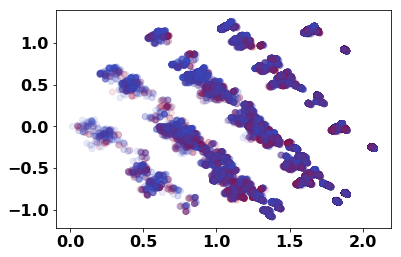

In [97]:
plt.scatter(supersparse_2d[:,0],supersparse_2d[:,1], cmap='coolwarm', c=supersparse_data[:,0], alpha=0.1)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


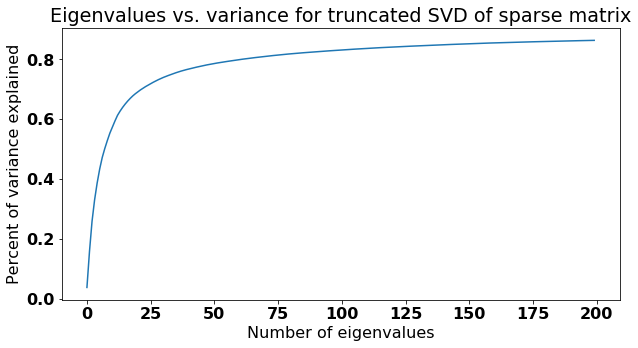

In [43]:
import matplotlib as mpl

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

mpl.rc('font', **font)

plt.figure(figsize=(10,5))
plt.plot(range(len(svd.explained_variance_ratio_)),np.cumsum(svd.explained_variance_ratio_))
plt.title('Eigenvalues vs. variance for truncated SVD of sparse matrix')
plt.xlabel('Number of eigenvalues')
plt.ylabel('Percent of variance explained')
plt.show()

In [51]:
np.cumsum(svd.explained_variance_ratio_)

array([ 0.03771886,  0.157958  ,  0.2585768 ,  0.3301086 ,  0.38633229,
        0.43328731,  0.47189734,  0.5019135 ,  0.52855446,  0.55342776,
        0.57410023,  0.59415145,  0.61288951,  0.62689587,  0.6393702 ,
        0.6505298 ,  0.66058563,  0.66964858,  0.67788234,  0.68508846,
        0.69147282,  0.69782007,  0.70338311,  0.70882042,  0.71378401,
        0.7186443 ,  0.72330496,  0.72774413,  0.73192363,  0.73588164,
        0.73955739,  0.74301056,  0.74621786,  0.74934035,  0.75239503,
        0.7554017 ,  0.75821227,  0.76080734,  0.76336585,  0.76555321,
        0.76771067,  0.76984284,  0.77185218,  0.77384585,  0.77577391,
        0.77762646,  0.77945836,  0.78123939,  0.78286889,  0.78444507,
        0.78599071,  0.78750768,  0.78894087,  0.79031591,  0.79163235,
        0.79293471,  0.79423152,  0.79549617,  0.7967389 ,  0.79796748,
        0.79917359,  0.80036825,  0.801509  ,  0.8026045 ,  0.80369541,
        0.80476478,  0.80579772,  0.80681482,  0.80781487,  0.80

In [170]:
from sklearn import cross_validation
from sklearn.metrics import zero_one_loss
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import precision_recall_fscore_support

X = supersparse_data[:,1:]
y = supersparse_data[:,0]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.8, random_state=0)

y_train = y_train.ravel()
y_test = y_test.ravel()

perc_none = Perceptron()
perc_l1 = Perceptron(penalty='l1')
perc_l2 = Perceptron(penalty='l2')

perc_none.fit(X_train, y_train)
perc_none_scores = cross_val_score(perc_none, X_test, y_test, cv=10)
print('perc_none_scores=',perc_none_scores)
print('mean =',np.mean(perc_none_scores),'std dev=',np.std(perc_none_scores))

perc_l1.fit(X_train, y_train)
perc_l1_scores = cross_val_score(perc_l1, X_test, y_test, cv=10)
print('perc_l1_scores=',perc_l1_scores)
print('mean =',np.mean(perc_l1_scores),'std dev=',np.std(perc_l1_scores))

perc_l2.fit(X_train, y_train)
perc_l2_scores = cross_val_score(perc_l2, X_test, y_test, cv=10)
print('perc_l2_scores=',perc_l2_scores)
print('mean =',np.mean(perc_l2_scores),'std dev=',np.std(perc_l2_scores))

lss = LassoCV()
lss.fit(X_train, y_train)

lss_scores = cross_val_score(lss, X_test, y_test, cv=10)
print('lss_scores=',lss_scores)
print('mean =',np.mean(lss_scores),'std dev=',np.std(lss_scores))


rc = RidgeClassifier()
rc.fit(X_train, y_train)

rc_scores = cross_val_score(rc, X_test, y_test, cv=10)
print('rc_scores=',rc_scores)
print('mean =',np.mean(rc_scores),'std dev=',np.std(rc_scores))


knc = KNeighborsClassifier()
knc.fit(X_train, y_train)

knc_scores = cross_val_score(knc, X_test, y_test, cv=10)
print('knc_scores=',knc_scores)
print('mean =',np.mean(knc_scores),'std dev=',np.std(knc_scores))

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfc_scores = cross_val_score(rfc, X_test, y_test, cv=10)
print('rfc_scores=',rfc_scores)
print('mean =',np.mean(rfc_scores),'std dev=',np.std(rfc_scores))

etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

etc_scores = cross_val_score(etc, X_test, y_test, cv=10)
print('etc_scores=',etc_scores)
print('mean =',np.mean(etc_scores),'std dev=',np.std(etc_scores))

perc_none_scores= [ 0.71589177  0.71703506  0.7148847   0.7173623   0.71545645  0.71374119
  0.7097389   0.71679055  0.71463973  0.71387724]
mean = 0.7149417875 std dev= 0.00211104718875
perc_l1_scores= [ 0.71608232  0.71703506  0.7148847   0.7173623   0.7148847   0.71374119
  0.7097389   0.7173623   0.7144491   0.71368662]
mean = 0.714922718093 std dev= 0.00218478726828
perc_l2_scores= [ 0.72313262  0.72313262  0.72041166  0.7238422   0.72174576  0.72136459
  0.71545645  0.72307986  0.72264583  0.72169272]
mean = 0.721650430213 std dev= 0.00228526114631
lss_scores= [ 0.03373569  0.02635584  0.03239853  0.03066922  0.0289301   0.02987768
  0.02637056  0.0308692   0.03509082  0.03007509]
mean = 0.0304372734723 std dev= 0.00269321564211
rc_scores= [ 0.75800305  0.75724085  0.75662283  0.75624166  0.75624166  0.75852868
  0.75586049  0.75852868  0.7518109   0.75638582]
mean = 0.756546463747 std dev= 0.00183236840558
knc_scores= [ 0.69721799  0.69340701  0.69125214  0.69658853  0.69487326 

In [172]:
from sklearn import cross_validation
from sklearn.metrics import zero_one_loss
from sklearn.linear_model import Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import precision_recall_fscore_support

X = supersparse_data[:,1:]
y = supersparse_data[:,0]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.8, random_state=0)

y_train = y_train.ravel()
y_test = y_test.ravel()

perc_none = Perceptron()
perc_l1 = Perceptron(penalty='l1')
perc_l2 = Perceptron(penalty='l2')

perc_none.fit(X_train, y_train)
perc_none_scores_prec = cross_val_score(perc_none, X_test, y_test, cv=10, scoring='precision')
perc_none_scores = cross_val_score(perc_none, X_test, y_test, cv=10, scoring='recall')
print('mean_prec =',np.mean(perc_none_scores_prec),'std dev_prec=',np.std(perc_none_scores_prec))
print('mean =',np.mean(perc_none_scores),'std dev=',np.std(perc_none_scores))

perc_l1.fit(X_train, y_train)
perc_l1_scores_prec = cross_val_score(perc_l1, X_test, y_test, cv=10, scoring='precision')
perc_l1_scores = cross_val_score(perc_l1, X_test, y_test, cv=10, scoring='recall')
print('mean_prec =',np.mean(perc_l1_scores_prec),'std dev_prec=',np.std(perc_l1_scores_prec))
print('mean =',np.mean(perc_l1_scores),'std dev=',np.std(perc_l1_scores))

perc_l2.fit(X_train, y_train)
perc_l2_scores_prec = cross_val_score(perc_l2, X_test, y_test, cv=10, scoring='precision')
perc_l2_scores = cross_val_score(perc_l2, X_test, y_test, cv=10, scoring='recall')
print('mean_prec =',np.mean(perc_l2_scores_prec),'std dev_prec=',np.std(perc_l2_scores_prec))
print('mean =',np.mean(perc_l2_scores),'std dev=',np.std(perc_l2_scores))

# lss = LassoCV()
# lss.fit(X_train, y_train)

# lss_scores = cross_val_score(lss, X_test, y_test, cv=10)
# print('lss_scores=',lss_scores)
# print('lss_scores=',lss_scores)
# print('mean =',np.mean(lss_scores),'std dev=',np.std(lss_scores))


# rc = RidgeClassifier()
# rc.fit(X_train, y_train)

# rc_scores = cross_val_score(rc, X_test, y_test, cv=10)
# print('rc_scores=',rc_scores)
# print('rc_scores=',rc_scores)
# print('mean =',np.mean(rc_scores),'std dev=',np.std(rc_scores))


knc = KNeighborsClassifier()
knc.fit(X_train, y_train)

knc_scores_prec = cross_val_score(knc, X_test, y_test, cv=10, scoring='precision')
knc_scores = cross_val_score(knc, X_test, y_test, cv=10, scoring='recall')
print('mean_prec =',np.mean(knc_scores_prec),'std dev_prec=',np.std(knc_scores_prec))
print('mean =',np.mean(knc_scores),'std dev=',np.std(knc_scores))

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfc_scores_prec = cross_val_score(rfc, X_test, y_test, cv=10, scoring='precision')
rfc_scores = cross_val_score(rfc, X_test, y_test, cv=10, scoring='recall')
print('mean_prec =',np.mean(rfc_scores_prec),'std dev_prec=',np.std(rfc_scores_prec))
print('mean =',np.mean(rfc_scores),'std dev=',np.std(rfc_scores))

etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

etc_scores_prec = cross_val_score(etc, X_test, y_test, cv=10, scoring='precision')
etc_scores = cross_val_score(etc, X_test, y_test, cv=10, scoring='recall')
print('mean_prec =',np.mean(etc_scores_prec),'std dev_prec=',np.std(etc_scores_prec))
print('mean =',np.mean(etc_scores),'std dev=',np.std(etc_scores))

mean_prec = 0.188781325061 std dev_prec= 0.0144179672706
mean = 0.0398700842093 std dev= 0.00317700929647
mean_prec = 0.188728784117 std dev_prec= 0.0142920290469
mean = 0.0398700842093 std dev= 0.00317700929647
mean_prec = 0.210429728308 std dev_prec= 0.019213977317
mean = 0.0380543094731 std dev= 0.00336841766351
mean_prec = 0.308861542037 std dev_prec= 0.014510995644
mean = 0.172492014829 std dev= 0.00812530451905
mean_prec = 0.503154312222 std dev_prec= 0.00945462152731
mean = 0.351035867707 std dev= 0.00821222233235
mean_prec = 0.474507570882 std dev_prec= 0.0101341128477
mean = 0.353154443351 std dev= 0.00756137169373


In [24]:
X_train.shape

(655, 102)

In [122]:
cross_val_score(rfc, X_test, y_test)

array([ 0.99554082,  0.99519726,  0.99599726])

In [11]:
data.to_csv('concatenated_data.csv', encoding='utf-8')
sample1.to_csv('concatenated_data_sparse.csv', encoding='utf-8')
sample2.to_csv('concatenated_data_supersparse.csv', encoding='utf-8')

In [138]:
def apply_classifiers(X,y,name):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=0)
    
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    if (len(np.unique(y_train)) <= 1 or len(np.unique(y_test)) <= 1):
        print('SMALL DATA SET!! ERROR!!!')
        return
        
    perc_l2 = Perceptron(penalty='l2')
    perc_l2.fit(X_train, y_train)
    perc_l2_scores = cross_val_score(perc_l2, X_test, y_test, cv=5)
    
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    rfc_scores = cross_val_score(rfc, X_test, y_test, cv=5)
    print('$\pm$',np.std(perc_l2_scores),'$\pm$',np.std(rfc_scores))
#     print('percl2 stats: mean =',np.mean(perc_l2_scores),'std dev=',np.std(perc_l2_scores))
#     print('rfc stats: mean =',np.mean(rfc_scores),'std dev=',np.std(rfc_scores))

In [78]:
apply_classifiers(X,y,'full')

for subset: full
percl2 stats: mean = 0.721650430213 std dev= 0.00228526114631
rfc stats: mean = 0.749380293334 std dev= 0.00540238245201


In [136]:
def loop_apply_to_column(col_name):
    for category in sample[col_name].unique():
        X_category = supersparse_data[sample[col_name] == category,1:]
        y_category = supersparse_data[sample[col_name] == category,0]
#         print('for column:', col_name)
#         print('for subset of category:', category)
        if (X_category.shape[0] >= 10 and y_category.shape[0] >= 0):
            apply_classifiers(X_category,y_category,category)
        else:
            print('TOO FEW DATA POINTS FOR THIS CATEGORY')

In [103]:
def loop_apply_to_columns(list):
    for col_name in list:
        loop_apply_to_column(col_name)

In [114]:
y_category_test = supersparse_data[sample['MARITAL_STATUS'] == 'LIFE PARTNER',0]
np.unique(y_category_test)

array([ 0.,  1.])

In [96]:
list(sample)

['NEXTVISIT',
 'AGE',
 'STAYLENGTH',
 'ADMISSION_TYPE',
 'INSURANCE',
 'MARITAL_STATUS',
 'ETHNICITY',
 'CURR_SERVICE',
 'DIAGNOSIS']

In [139]:
loop_apply_to_columns(['ADMISSION_TYPE','INSURANCE','MARITAL_STATUS','CURR_SERVICE'])

$\pm$ 0.000555413083056 $\pm$ 0.00540573615281
$\pm$ 0.00339078562056 $\pm$ 0.00954066288622
$\pm$ 0.125447052044 $\pm$ 0.0280389103976
$\pm$ 0.0393069479917 $\pm$ 0.0622290312795


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


$\pm$ 0.195818673278 $\pm$ 0.00665603797933
$\pm$ 0.212660662575 $\pm$ 0.00341480660225
$\pm$ 0.00415081063403 $\pm$ 0.0124831847334
$\pm$ 0.296505946189 $\pm$ 0.0153993355039
$\pm$ 0.207339142777 $\pm$ 0.021498626517
$\pm$ 0.178505556915 $\pm$ 0.00319022472137
$\pm$ 0.24799283067 $\pm$ 0.00754669385129
TOO FEW DATA POINTS FOR THIS CATEGORY
$\pm$ 0.00767738952992 $\pm$ 0.00865754701242
$\pm$ 0.166114788858 $\pm$ 0.0101033818078
$\pm$ 0.0127812327187 $\pm$ 0.0317410022892
$\pm$ 0.0533888385268 $\pm$ 0.0405616738626

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)



$\pm$ 0.33993463424 $\pm$ 0.326598632371
$\pm$ 0.189553810598 $\pm$ 0.00463683458686
$\pm$ 0.335066974667 $\pm$ 0.0046909845356
$\pm$ 0.286372472618 $\pm$ 0.00543717978648
$\pm$ 0.0416530443776 $\pm$ 0.0197572218466
$\pm$ 0.0205013089005 $\pm$ 0.0247601381463
$\pm$ 0.0080970306107 $\pm$ 0.0247057352228
$\pm$ 0.246307456728 $\pm$ 0.0754081263103
$\pm$ 0.11366358123 $\pm$ 0.097174751281
$\pm$ 0.00890577248536 $\pm$ 0.0271836304268
$\pm$ 0.00620992962568 $\pm$ 0.00987509518237
$\pm$ 0.0779303857524 $\pm$ 0.0371141098961
$\pm$ 0.0321678884152 $\pm$ 0.0329910917945
$\pm$ 0.180563280216 $\pm$ 0.0282516178347
$\pm$ 0.014014239478 $\pm$ 0.0138049618445


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


$\pm$ 0.122666666667 $\pm$ 0.0444272188841
$\pm$ 0.0341143330746 $\pm$ 0.0342563837346
TOO FEW DATA POINTS FOR THIS CATEGORY
$\pm$ 0.107629094759 $\pm$ 0.109090909091
TOO FEW DATA POINTS FOR THIS CATEGORY
TOO FEW DATA POINTS FOR THIS CATEGORY
